# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
from datetime import datetime
import joblib
import matplotlib as mpl
import cmasher as cm
import colorcet as cc

from epics import ca
ca.finalize_libca()

%matplotlib inline

File motors_configuration.ini doesn't exist: created empty ini file.
28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':False})

In [5]:
DEFAULT_RANDOM_SEED = 1010

In [6]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 1e3,
            "sum_intensity_hard_constraint": 1e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [7]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [8]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [9]:
2560 * 0.65 * 1e-3

1.6640000000000001

In [10]:
detector_x = 2160 * 0.65 * 1e-3 / 2
detector_y = 2560 * 0.65 * 1e-3 / 2
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024 // 2,
    nbins_v = 1024 // 2,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.3, 0.3]
yrange_plot = [-0.3, 0.3]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [11]:
save_dir = Path(Path.home() / "code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi")

In [12]:
!rm -r $save_dir

In [13]:
save_dir.mkdir()

In [14]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.35100000000000003, 0.35100000000000003], yrange=[-0.41600000000000004, 0.41600000000000004], nbins_h=512, nbins_v=512, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=1010, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7F8338B0A9E0)


In [15]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.3, 0.3], yrange=[-0.3, 0.3], nbins_h=256, nbins_v=256, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7f832856ddc0>)

In [16]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 1000.0, 'sum_intensity_hard_constraint': 1000.0, 'loss_parameters': ['fwhm', 'peak_distance', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [17]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


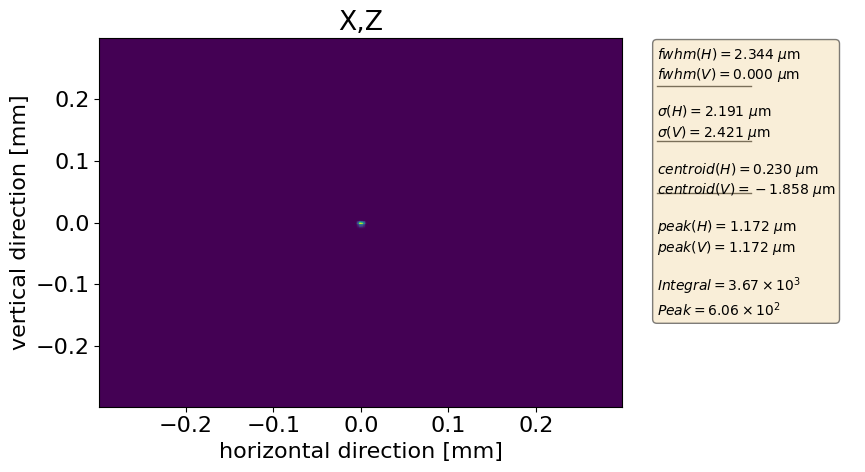

In [18]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

{'h_sigma': 0.0021538802375110633, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.0002107472409639045, 'h_peak': 0.0006855468749999982, 'v_sigma': 0.0023423419894278534, 'v_fwhm': 0.003249999999999975, 'v_centroid': -0.0018443099868134482, 'v_peak': 0.0008124999999999938, 'integral_intensity': 3667.060651783776, 'peak_intensity': 292.9558493423641, 'gaussian_fit': {}}


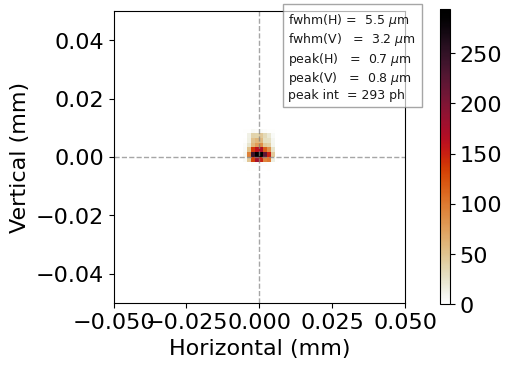

In [19]:
dwd = dict(dw._DictionaryWrapper__dictionary)
print(dwd)
hist = hist
plt.figure(figsize=[5, 5], constrained_layout=True, dpi=100)
ax = plt.gca()

plt.pcolormesh(hist.hh, hist.vv[::-1], hist.data_2D.T, cmap=apu.CMAP, rasterized=True)
plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)
# ax.set_yticklabels([])


ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.show()

In [20]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi/focused_beam.joblib']

In [21]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 6.375e-03
Focused beam system peak_distance: 1.063e-03
Focused beam system negative_log_peak_intensity: -5.680e+00


In [22]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [23]:
init_motors_ranges = {k: np.array(v) / 2 for k,v in opt_params.move_motors_ranges.items()}

In [24]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=init_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-178.1, -160.1, 0.17104733853924986, 0.0288, 426.0, 0.17237733853924986, -0.0027]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-10.125192925960693, 0.89514328092109, 0.0008353534662269215, 0.01444397546666409, 6.976390782913892, 0.0004922897119247914, -0.00271735054988129]


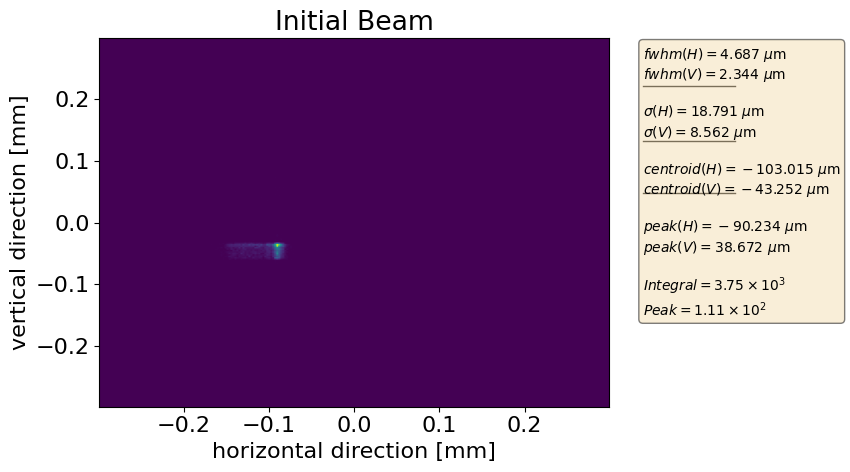

Perturbed beam system fwhm: 8.505e-03
Perturbed beam system peak_distance: 9.636e-02
Perturbed beam system negative_log_peak_intensity: -3.935e+00


In [25]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [26]:
{k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}

{'hb_1': -178.1,
 'hb_2': -160.1,
 'hb_pitch': 0.17104733853924986,
 'hb_trans': 0.0288,
 'vb_bender': 426.0,
 'vb_pitch': 0.17237733853924986,
 'vb_trans': -0.0027}

In [27]:
hist_pert.data_2D.max()

51.138934383234826

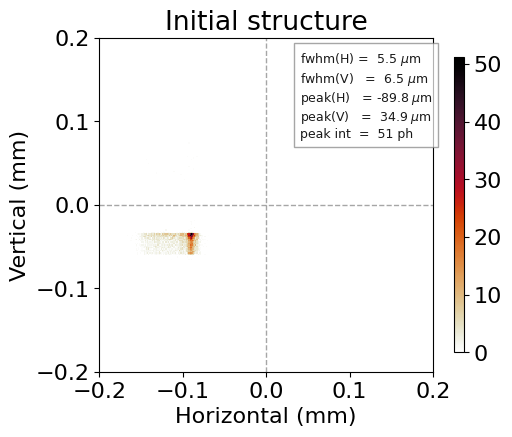

In [28]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[5,5], constrained_layout=True, dpi=100)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=apu.CMAP)#, norm=mpl.colors.LogNorm(1, 4e2))
plt.xlim(-0.2,0.2)
plt.ylim(-0.2,0.2)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.6,
    0.7,
    text,
    color="black",
    alpha=0.9,
    fontsize=9,
    bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    transform=ax.transAxes,
)
plt.show()

In [29]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### Calculating without removing noise

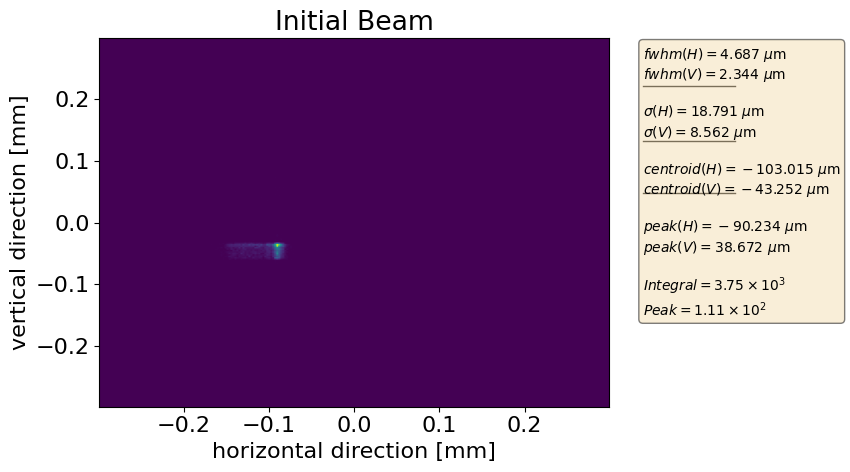

In [30]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [31]:
hist_pert.data_2D.max()

51.138934383234826

In [32]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 8.505e-03
Perturbed beam system peak_distance: 9.636e-02
Perturbed beam system negative_log_peak_intensity: -3.935e+00


In [33]:
opt_params = OptimizationParameters()

In [34]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [35]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [36]:
attribs_init

{'fwhm': 0.008504608700029895,
 'peak_distance': 0.09636317557344143,
 'negative_log_peak_intensity': -3.9345461323998494}

In [37]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-08-09 15:11:38,705] A new study created in memory with name: no-name-5bd0408d-e3bb-4d9c-aca6-d6125b9e95ea


In [38]:
for i in range(6):
    opt_trial.trials(25)
    joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-08-09 15:11:47,217] Trial 0 finished with values: [0.008504608700029895, 0.09636317557344143, -3.9345461323998494] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:11:55,849] Trial 1 finished with values: [0.04935937499999987, 0.10354627172001646, -3.5561805963774247] and parameters: {'hb_1': -5.0, 'hb_2': -17.0, 'hb_pitch': -0.0017100000000000001, 'hb_trans': -0.0185, 'vb_bender': -4.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015700000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:04,396] Trial 2 finished with values: [0.0276137959816397, 0.11780661459067017, -3.3795842256844235] and parameters: {'hb_1': 1.0, 'hb_2': -5.0, 'hb_pitch': 0.00013999999999999993, 'hb_trans': -0.0138, 'vb_bender': -3.0, 'vb_pitch': 0.0013000000000000004, 'vb_trans': -0.013699999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:13,105] Trial 3 finished with values: [0.024465023375717557, 0.13701033695233808, -2.758501419839768] and parameters: {'hb_1': 12.0, 'hb_2': -20.0, 'hb_pitch': -1.0000000000000026e-05, 'hb_trans': 0.004800000000000006, 'vb_bender': 3.0, 'vb_pitch': -0.00118, 'vb_trans': -0.012299999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:21,726] Trial 4 finished with values: [0.08258873660531699, 0.20672470104967713, -1.7809951767021481] and parameters: {'hb_1': 20.0, 'hb_2': -14.0, 'hb_pitch': 0.0008100000000000004, 'hb_trans': -0.005499999999999998, 'vb_bender': 15.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.004799999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:30,270] Trial 5 finished with values: [0.14260300895865555, 0.2111533974069106, -3.0115581668872053] and parameters: {'hb_1': -4.0, 'hb_2': -9.0, 'hb_pitch': 0.0010700000000000002, 'hb_trans': 0.0284, 'vb_bender': -6.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.022200000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:38,936] Trial 6 finished with values: [0.06205161229082272, 0.19723619397755626, -2.1091949032435076] and parameters: {'hb_1': 16.0, 'hb_2': -20.0, 'hb_pitch': 0.0009500000000000003, 'hb_trans': -0.0121, 'vb_bender': 12.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.017099999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:47,503] Trial 7 finished with values: [0.1291774391719216, 0.08863116564912432, -1.6122553556835726] and parameters: {'hb_1': -8.0, 'hb_2': 24.0, 'hb_pitch': -0.00025, 'hb_trans': -0.0172, 'vb_bender': 13.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': -0.014099999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:12:56,012] Trial 8 finished with values: [0.11521772125422182, 0.0907383249092153, -2.340557838260035] and parameters: {'hb_1': -7.0, 'hb_2': 24.0, 'hb_pitch': -0.00017999999999999982, 'hb_trans': -0.0206, 'vb_bender': -16.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.003499999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:13:04,688] Trial 9 finished with values: [0.009597656249999975, 0.1666668649608704, -4.14594750638529] and parameters: {'hb_1': -9.0, 'hb_2': 1.0, 'hb_pitch': 0.0007100000000000001, 'hb_trans': 0.0021000000000000046, 'vb_bender': -15.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.012499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:13:15,888] Trial 10 finished with values: [0.0070454294959375096, 0.07352985157348148, -4.5111661918888775] and parameters: {'hb_1': -4.0, 'hb_2': 0.0, 'hb_pitch': -0.0003399999999999998, 'hb_trans': -0.003199999999999998, 'vb_bender': -4.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': -0.007099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:13:26,828] Trial 11 finished with values: [0.0317021857245192, 0.04271479717682933, -3.79515014277959] and parameters: {'hb_1': -3.0, 'hb_2': -6.0, 'hb_pitch': -0.0006299999999999999, 'hb_trans': -0.0038999999999999972, 'vb_bender': -8.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.0026999999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:13:38,932] Trial 12 finished with values: [0.011088467051964366, 0.054431347399659616, -4.432215553576852] and parameters: {'hb_1': -3.0, 'hb_2': 1.0, 'hb_pitch': -0.00067, 'hb_trans': 0.00030000000000000165, 'vb_bender': -8.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': -0.0072999999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:13:51,283] Trial 13 finished with values: [0.016771041180130213, 0.052074983416777625, -4.18899725304148] and parameters: {'hb_1': -3.0, 'hb_2': 2.0, 'hb_pitch': -0.00059, 'hb_trans': -0.005199999999999996, 'vb_bender': -7.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': -0.003599999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:14:04,160] Trial 14 finished with values: [0.004113281249999989, 0.03258100028762826, -4.859701496369439] and parameters: {'hb_1': -2.0, 'hb_2': 0.0, 'hb_pitch': -0.00066, 'hb_trans': -9.999999999999593e-05, 'vb_bender': -5.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.010299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:14:13,974] Trial 15 finished with values: [0.06041560366342131, 0.05602445289926851, -3.5185501587395813] and parameters: {'hb_1': 1.0, 'hb_2': -9.0, 'hb_pitch': -0.0006199999999999999, 'hb_trans': 0.002800000000000004, 'vb_bender': -9.0, 'vb_pitch': -0.00156, 'vb_trans': -0.011399999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:14:25,590] Trial 16 finished with values: [0.01700921740005979, 0.015479225387906845, -3.069901977826307] and parameters: {'hb_1': -4.0, 'hb_2': 1.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': 0.0021000000000000046, 'vb_bender': 4.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.0201}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:14:36,207] Trial 17 finished with values: [0.0057200519351335265, 0.008565677025576778, -4.3681260101955335] and parameters: {'hb_1': -2.0, 'hb_2': 0.0, 'hb_pitch': -0.0007699999999999999, 'hb_trans': -0.0005999999999999964, 'vb_bender': -2.0, 'vb_pitch': -0.00058, 'vb_trans': -0.012499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:14:50,503] Trial 18 finished with values: [0.011088467051964366, 0.04142294295181484, -4.375961901773744] and parameters: {'hb_1': 0.0, 'hb_2': -4.0, 'hb_pitch': -0.00117, 'hb_trans': -0.003599999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': -0.013399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:15:05,041] Trial 19 finished with values: [0.01013299094508445, 0.040897235433698775, -4.4289537215906165] and parameters: {'hb_1': 0.0, 'hb_2': -2.0, 'hb_pitch': -0.0005399999999999999, 'hb_trans': -0.005199999999999996, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0194}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:15:17,489] Trial 20 finished with values: [0.0057200519351335265, 0.03387905831326492, -4.555091849155941] and parameters: {'hb_1': 1.0, 'hb_2': -1.0, 'hb_pitch': -0.0007799999999999999, 'hb_trans': -0.0036999999999999984, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': -0.016}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:15:33,132] Trial 21 finished with values: [0.030207801831710655, 0.03136950836146604, -4.475299568765729] and parameters: {'hb_1': 7.0, 'hb_2': 0.0, 'hb_pitch': -0.00114, 'hb_trans': -0.002199999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0218}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:15:46,904] Trial 22 finished with values: [0.026050781249999932, 0.029420372582727332, -3.8490997315391815] and parameters: {'hb_1': -18.0, 'hb_2': 4.0, 'hb_pitch': -0.00073, 'hb_trans': 0.005200000000000003, 'vb_bender': -6.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': -0.007399999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:16:02,705] Trial 23 finished with values: [0.00733784669645152, 0.059873618761030825, -4.108858075856401] and parameters: {'hb_1': -7.0, 'hb_2': -2.0, 'hb_pitch': -0.00114, 'hb_trans': 0.0011000000000000038, 'vb_bender': -14.0, 'vb_pitch': 0.00116, 'vb_trans': -0.0293}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:16:14,983] Trial 24 finished with values: [0.005484374999999986, 0.03228258961411869, -4.820176834884771] and parameters: {'hb_1': -5.0, 'hb_2': -1.0, 'hb_pitch': -0.0009, 'hb_trans': 0.0017000000000000001, 'vb_bender': -5.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.014699999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:16:26,519] Trial 25 finished with values: [0.00733784669645152, 0.05464860618188986, -5.067743527074733] and parameters: {'hb_1': 11.0, 'hb_2': -4.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': -0.015199999999999998, 'vb_bender': -11.0, 'vb_pitch': 0.0012600000000000003, 'vb_trans': -0.025099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:16:40,702] Trial 26 finished with values: [0.0057200519351335265, 0.01364421881911304, -4.838327256802793] and parameters: {'hb_1': -5.0, 'hb_2': -1.0, 'hb_pitch': -0.0007099999999999999, 'hb_trans': 0.0006000000000000033, 'vb_bender': -6.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.014099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:16:55,612] Trial 27 finished with values: [0.03431584065057503, 0.014231462299973139, -4.043112289392032] and parameters: {'hb_1': 6.0, 'hb_2': -5.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': -0.009599999999999997, 'vb_bender': -12.0, 'vb_pitch': 0.0007400000000000002, 'vb_trans': -0.0271}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:17:11,315] Trial 28 finished with values: [0.022176934103928733, 0.05725396771403921, -3.886787495596289] and parameters: {'hb_1': 6.0, 'hb_2': -2.0, 'hb_pitch': -0.0013, 'hb_trans': -0.009999999999999998, 'vb_bender': 0.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.005200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:17:26,556] Trial 29 finished with values: [0.0057200519351335265, 0.013050707152635004, -4.923555878705089] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': -0.00073, 'hb_trans': -0.0013999999999999985, 'vb_bender': -6.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.008999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:17:40,061] Trial 30 finished with values: [0.006378456525022422, 0.0479815972734381, -4.788392840785254] and parameters: {'hb_1': 4.0, 'hb_2': -1.0, 'hb_pitch': -0.00082, 'hb_trans': -0.014299999999999997, 'vb_bender': -12.0, 'vb_pitch': 0.00116, 'vb_trans': -0.025799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:17:56,506] Trial 31 finished with values: [0.03598022680850413, 0.11451245344311158, -3.5617532966200796] and parameters: {'hb_1': 13.0, 'hb_2': -3.0, 'hb_pitch': 3.000000000000008e-05, 'hb_trans': -0.0022999999999999965, 'vb_bender': -12.0, 'vb_pitch': 0.0015400000000000001, 'vb_trans': -0.014799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:18:12,562] Trial 32 finished with values: [0.007586827517627256, 0.03009346104816901, -4.654423647919383] and parameters: {'hb_1': -3.0, 'hb_2': -2.0, 'hb_pitch': -0.00108, 'hb_trans': -0.0172, 'vb_bender': -8.0, 'vb_pitch': 0.0008000000000000004, 'vb_trans': -0.020699999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:18:29,370] Trial 33 finished with values: [0.018118092450582365, 0.037864777800188744, -4.421314915693417] and parameters: {'hb_1': 11.0, 'hb_2': -2.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': -0.021599999999999998, 'vb_bender': -10.0, 'vb_pitch': 0.0009200000000000002, 'vb_trans': -0.023}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:18:47,007] Trial 34 finished with values: [0.06583255867160244, 0.1015672764990084, -3.3407639663219046] and parameters: {'hb_1': 6.0, 'hb_2': 4.0, 'hb_pitch': -0.00058, 'hb_trans': 0.009900000000000006, 'vb_bender': -9.0, 'vb_pitch': -0.00116, 'vb_trans': -0.013499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:19:01,770] Trial 35 finished with values: [0.005484374999999986, 0.052489742512230375, -4.313144091187049] and parameters: {'hb_1': -18.0, 'hb_2': 0.0, 'hb_pitch': -0.0003699999999999999, 'hb_trans': -0.010699999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.0016999999999999967}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:19:20,377] Trial 36 finished with values: [0.07331913926288924, 0.08852880806455218, -2.4676402722517663] and parameters: {'hb_1': -3.0, 'hb_2': -8.0, 'hb_pitch': -0.0016099999999999999, 'hb_trans': 0.00040000000000000105, 'vb_bender': 4.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': -0.016}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:19:39,136] Trial 37 finished with values: [0.006375019148255531, 0.014937652331736686, -4.694450500613872] and parameters: {'hb_1': -11.0, 'hb_2': -1.0, 'hb_pitch': -0.00073, 'hb_trans': -0.005999999999999998, 'vb_bender': -7.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.0093}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:19:55,407] Trial 38 finished with values: [0.013710937499999964, 0.07868482587298747, -4.364372668240525] and parameters: {'hb_1': -13.0, 'hb_2': -3.0, 'hb_pitch': -0.00047999999999999996, 'hb_trans': -0.022099999999999998, 'vb_bender': -12.0, 'vb_pitch': -0.00136, 'vb_trans': -0.024399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:20:06,257] Trial 39 finished with values: [0.006375019148255531, 0.012621592600062887, -4.728997369285345] and parameters: {'hb_1': -6.0, 'hb_2': -1.0, 'hb_pitch': -0.00075, 'hb_trans': -0.007199999999999998, 'vb_bender': -7.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': -0.014799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:20:23,228] Trial 40 finished with values: [0.008412079218732188, 0.044611674950629635, -4.342964130370808] and parameters: {'hb_1': -3.0, 'hb_2': -2.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': -0.014199999999999997, 'vb_bender': -10.0, 'vb_pitch': 0.0011000000000000003, 'vb_trans': -0.024599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:20:40,227] Trial 41 finished with values: [0.009734250381676215, 0.017180899944603995, -4.557433949565025] and parameters: {'hb_1': -7.0, 'hb_2': -2.0, 'hb_pitch': -0.00076, 'hb_trans': -0.0033999999999999968, 'vb_bender': -11.0, 'vb_pitch': -0.0005, 'vb_trans': -0.014499999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:20:57,096] Trial 42 finished with values: [0.0057200519351335265, 0.01261811882809834, -4.584170158940189] and parameters: {'hb_1': -10.0, 'hb_2': 0.0, 'hb_pitch': -0.00074, 'hb_trans': -0.0001999999999999988, 'vb_bender': -7.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.009199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:21:14,326] Trial 43 finished with values: [0.0057200519351335265, 0.010144341162603447, -4.708836460994703] and parameters: {'hb_1': -5.0, 'hb_2': -1.0, 'hb_pitch': -0.0008799999999999999, 'hb_trans': -0.013699999999999997, 'vb_bender': -12.0, 'vb_pitch': 0.0005600000000000002, 'vb_trans': -0.0172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:21:29,410] Trial 44 finished with values: [0.00884527165023244, 0.021329953651145366, -3.9364612752919372] and parameters: {'hb_1': -8.0, 'hb_2': -3.0, 'hb_pitch': -0.0009, 'hb_trans': -0.021199999999999997, 'vb_bender': -1.0, 'vb_pitch': -0.00066, 'vb_trans': 0.003700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:21:45,924] Trial 45 finished with values: [0.009734250381676215, 0.03605626990915676, -4.403380659236544] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': -0.00076, 'hb_trans': -0.008399999999999998, 'vb_bender': -12.0, 'vb_pitch': -0.0014, 'vb_trans': 0.0075}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:22:02,504] Trial 46 finished with values: [0.00884527165023244, 0.005315380437518706, -4.691128702040404] and parameters: {'hb_1': -9.0, 'hb_2': -2.0, 'hb_pitch': -0.00081, 'hb_trans': -0.015599999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00066, 'vb_trans': -0.006999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:22:17,363] Trial 47 finished with values: [0.0057200519351335265, 0.004206039609366094, -4.5683404627407125] and parameters: {'hb_1': -8.0, 'hb_2': 0.0, 'hb_pitch': -0.00089, 'hb_trans': -0.008499999999999997, 'vb_bender': -11.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.024599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:22:36,183] Trial 48 finished with values: [0.006375019148255531, 0.06685559853026586, -4.108606489506427] and parameters: {'hb_1': -25.0, 'hb_2': -1.0, 'hb_pitch': -0.00056, 'hb_trans': -0.0179, 'vb_bender': -1.0, 'vb_pitch': -0.00106, 'vb_trans': 0.012500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:22:52,376] Trial 49 finished with values: [0.00442263582511622, 0.0060479274888510775, -5.150711184000635] and parameters: {'hb_1': -16.0, 'hb_2': 0.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': -0.017799999999999996, 'vb_bender': -9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.009799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:23:09,838] Trial 50 finished with values: [0.0057200519351335265, 0.0715788739125049, -4.806352621005097] and parameters: {'hb_1': -1.0, 'hb_2': 0.0, 'hb_pitch': -0.00108, 'hb_trans': -0.0218, 'vb_bender': -11.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': -0.009099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:23:25,409] Trial 51 finished with values: [0.012339843749999968, 0.015788498224276398, -4.266133510554045] and parameters: {'hb_1': -22.0, 'hb_2': -5.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': -0.0162, 'vb_bender': -11.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.009999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:23:44,462] Trial 52 finished with values: [0.012339843749999968, 0.03247580046926305, -4.454289580571743] and parameters: {'hb_1': -12.0, 'hb_2': 3.0, 'hb_pitch': -0.00118, 'hb_trans': -0.012799999999999999, 'vb_bender': -11.0, 'vb_pitch': -0.00058, 'vb_trans': -0.008499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:24:01,021] Trial 53 finished with values: [0.024679687499999936, 0.018143782466553182, -3.5410451082345524] and parameters: {'hb_1': -24.0, 'hb_2': -6.0, 'hb_pitch': -0.00076, 'hb_trans': -0.028499999999999998, 'vb_bender': -15.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': 0.013200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:24:19,806] Trial 54 finished with values: [0.012446379745709724, 0.05423466623063779, -4.60145106685408] and parameters: {'hb_1': -2.0, 'hb_2': 1.0, 'hb_pitch': -0.00059, 'hb_trans': -0.010799999999999997, 'vb_bender': -7.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': -0.026}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:24:37,258] Trial 55 finished with values: [0.007586827517627256, 0.03393085365478494, -4.4902075433473065] and parameters: {'hb_1': 3.0, 'hb_2': -1.0, 'hb_pitch': -0.00101, 'hb_trans': 0.006900000000000003, 'vb_bender': -5.0, 'vb_pitch': 0.0009000000000000002, 'vb_trans': -0.0286}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:24:54,867] Trial 56 finished with values: [0.012003295445938962, 0.014958698760574719, -3.8210007646781214] and parameters: {'hb_1': -19.0, 'hb_2': 1.0, 'hb_pitch': -0.0006899999999999999, 'hb_trans': -0.0202, 'vb_bender': -15.0, 'vb_pitch': 0.00068, 'vb_trans': -0.015499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:25:18,255] Trial 57 finished with values: [0.005242287920517273, 0.02720577921618879, -4.474419124381163] and parameters: {'hb_1': -18.0, 'hb_2': 0.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': 0.008, 'vb_bender': -12.0, 'vb_pitch': -0.00168, 'vb_trans': -0.005499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:25:34,179] Trial 58 finished with values: [0.015428226295526495, 0.022779013525256932, -3.8497203657111174] and parameters: {'hb_1': -5.0, 'hb_2': 2.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': -0.0298, 'vb_bender': -11.0, 'vb_pitch': -0.002, 'vb_trans': 0.013400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:25:50,080] Trial 59 finished with values: [0.006375019148255531, 0.024228045170009274, -4.661963583075418] and parameters: {'hb_1': -21.0, 'hb_2': -1.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': -0.015299999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00172, 'vb_trans': -0.004799999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:26:08,108] Trial 60 finished with values: [0.006375019148255531, 0.11446420703134538, -4.369468317171646] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.00184, 'hb_trans': -0.009799999999999996, 'vb_bender': -12.0, 'vb_pitch': -0.00172, 'vb_trans': -0.0186}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/p

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:26:27,127] Trial 61 finished with values: [0.01516932073713175, 0.0370261917715786, -4.549923355031704] and parameters: {'hb_1': 11.0, 'hb_2': -2.0, 'hb_pitch': -0.00105, 'hb_trans': -0.0208, 'vb_bender': -15.0, 'vb_pitch': -0.0006399999999999999, 'vb_trans': -0.0005999999999999964}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:26:41,510] Trial 62 finished with values: [0.006375019148255531, 0.006640558650863398, -5.017288825617416] and parameters: {'hb_1': -8.0, 'hb_2': 0.0, 'hb_pitch': -0.00089, 'hb_trans': -0.016999999999999998, 'vb_bender': -10.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.0076999999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:27:01,114] Trial 63 finished with values: [0.0070454294959375096, 0.009445346627122478, -4.7061230924122945] and parameters: {'hb_1': -11.0, 'hb_2': 1.0, 'hb_pitch': -0.0009399999999999999, 'hb_trans': 0.0126, 'vb_bender': -6.0, 'vb_pitch': -0.0006799999999999998, 'vb_trans': -0.006699999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:27:17,207] Trial 64 finished with values: [0.006375019148255531, 0.022181599350857523, -4.113414312552028] and parameters: {'hb_1': -15.0, 'hb_2': -1.0, 'hb_pitch': -0.00093, 'hb_trans': -0.005799999999999996, 'vb_bender': -2.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': -0.012299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:27:35,408] Trial 65 finished with values: [0.009802754416011033, 0.022456238723866713, -3.67421353732333] and parameters: {'hb_1': -21.0, 'hb_2': 0.0, 'hb_pitch': -0.0009, 'hb_trans': -0.0214, 'vb_bender': 2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0233}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:27:54,562] Trial 66 finished with values: [0.009597656249999975, 0.010860333429209395, -4.531024251903303] and parameters: {'hb_1': -22.0, 'hb_2': 1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.002700000000000001, 'vb_bender': -4.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.014400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:28:15,672] Trial 67 finished with values: [0.00733784669645152, 0.05059571820413304, -4.568634095311059] and parameters: {'hb_1': -21.0, 'hb_2': 0.0, 'hb_pitch': -0.00131, 'hb_trans': -0.015799999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.0018, 'vb_trans': -0.0028999999999999963}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:28:34,750] Trial 68 finished with values: [0.0057200519351335265, 0.05157780967230034, -4.661902641341744] and parameters: {'hb_1': -19.0, 'hb_2': 0.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0288, 'vb_bender': -10.0, 'vb_pitch': -0.00076, 'vb_trans': -0.0020999999999999977}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:28:52,924] Trial 69 finished with values: [0.01013299094508445, 0.010584723934417105, -4.564186865961036] and parameters: {'hb_1': -6.0, 'hb_2': 1.0, 'hb_pitch': -0.00083, 'hb_trans': -0.004299999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': 0.029000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:29:13,056] Trial 70 finished with values: [0.01013299094508445, 0.05284638195375162, -4.134840666972294] and parameters: {'hb_1': -18.0, 'hb_2': 1.0, 'hb_pitch': -0.0003799999999999999, 'hb_trans': -0.0033999999999999968, 'vb_bender': -11.0, 'vb_pitch': -0.00198, 'vb_trans': -0.028499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:29:29,607] Trial 71 finished with values: [0.006855468749999982, 0.02367867394433148, -4.8377630878308455] and parameters: {'hb_1': -22.0, 'hb_2': -2.0, 'hb_pitch': -0.00091, 'hb_trans': -0.026699999999999998, 'vb_bender': -6.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.014000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:29:49,831] Trial 72 finished with values: [0.0057200519351335265, 0.03995978627564913, -4.890711876721009] and parameters: {'hb_1': -3.0, 'hb_2': 0.0, 'hb_pitch': -0.0009, 'hb_trans': -0.006499999999999999, 'vb_bender': -10.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': -0.0191}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:30:06,010] Trial 73 finished with values: [0.0057200519351335265, 0.03986558574648566, -4.493331197178857] and parameters: {'hb_1': -20.0, 'hb_2': 0.0, 'hb_pitch': -0.0008799999999999999, 'hb_trans': 0.019700000000000002, 'vb_bender': -6.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.012100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:30:25,473] Trial 74 finished with values: [0.0057200519351335265, 0.011104763356125903, -4.887584358787203] and parameters: {'hb_1': -18.0, 'hb_2': 0.0, 'hb_pitch': -0.0009, 'hb_trans': -0.006999999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00066, 'vb_trans': 0.00020000000000000226}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:30:46,473] Trial 75 finished with values: [0.015428226295526495, 0.037676753091810615, -4.196748847652143] and parameters: {'hb_1': -18.0, 'hb_2': 2.0, 'hb_pitch': -0.00056, 'hb_trans': -0.024499999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.0019000000000000059}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:31:06,253] Trial 76 finished with values: [0.006375019148255531, 0.020132075896164222, -4.457099416303693] and parameters: {'hb_1': -15.0, 'hb_2': 0.0, 'hb_pitch': -0.0006899999999999999, 'hb_trans': -0.007999999999999997, 'vb_bender': -6.0, 'vb_pitch': -0.00166, 'vb_trans': 0.012100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:31:27,257] Trial 77 finished with values: [0.0057200519351335265, 0.045405260362755544, -4.790421790106375] and parameters: {'hb_1': 3.0, 'hb_2': -2.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -10.0, 'vb_pitch': -0.001, 'vb_trans': 0.0058}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:31:48,724] Trial 78 finished with values: [0.00442263582511622, 0.03009346104816901, -4.73545289881436] and parameters: {'hb_1': -24.0, 'hb_2': 0.0, 'hb_pitch': -0.0011099999999999999, 'hb_trans': 0.014900000000000004, 'vb_bender': -10.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.026100000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:32:08,510] Trial 79 finished with values: [0.0057200519351335265, 0.00628750010920802, -4.876618290900242] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': -0.0008699999999999999, 'hb_trans': -0.015399999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00164, 'vb_trans': 0.020500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:32:31,524] Trial 80 finished with values: [0.0070454294959375096, 0.03125734441283252, -4.883357855076417] and parameters: {'hb_1': -17.0, 'hb_2': -1.0, 'hb_pitch': -0.00101, 'hb_trans': -0.007099999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:32:55,349] Trial 81 finished with values: [0.006375019148255531, 0.025932182557463292, -4.911589328710577] and parameters: {'hb_1': -14.0, 'hb_2': -1.0, 'hb_pitch': -0.0009, 'hb_trans': -0.026299999999999997, 'vb_bender': -8.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': 0.006000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:33:13,593] Trial 82 finished with values: [0.2405351722360801, 0.08353366289746099, -2.2136758370129326] and parameters: {'hb_1': -23.0, 'hb_2': -1.0, 'hb_pitch': -0.00123, 'hb_trans': -0.004699999999999999, 'vb_bender': -7.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.004299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:33:35,872] Trial 83 finished with values: [0.2276486905970812, 0.1254883728872477, -1.9789835250528545] and parameters: {'hb_1': -12.0, 'hb_2': 1.0, 'hb_pitch': -0.00103, 'hb_trans': -0.014499999999999999, 'vb_bender': -9.0, 'vb_pitch': -0.00114, 'vb_trans': -0.008399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:33:49,370] Trial 84 finished with values: [0.05220282861053979, 0.04968088937605241, -3.7960435484605988] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': 0.004700000000000003, 'vb_bender': -7.0, 'vb_pitch': 0.0012000000000000001, 'vb_trans': -0.0253}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:34:02,403] Trial 85 finished with values: [0.008412079218732188, 0.01740339820826829, -3.9464881626936994] and parameters: {'hb_1': -24.0, 'hb_2': 1.0, 'hb_pitch': -0.0009, 'hb_trans': -0.000899999999999998, 'vb_bender': 0.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': 0.026800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:34:16,038] Trial 86 finished with values: [0.008412079218732188, 0.057789246570582285, -3.9553137065867894] and parameters: {'hb_1': -9.0, 'hb_2': 2.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': -0.006899999999999996, 'vb_bender': -18.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': 0.025800000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:34:33,886] Trial 87 finished with values: [0.05075648810344066, 0.02118304099364691, -4.255737256341412] and parameters: {'hb_1': 9.0, 'hb_2': -3.0, 'hb_pitch': -0.00103, 'hb_trans': 0.006400000000000003, 'vb_bender': -13.0, 'vb_pitch': 0.0006200000000000003, 'vb_trans': -0.0157}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:34:52,442] Trial 88 finished with values: [0.01013299094508445, 0.007387275694977363, -4.597051113758451] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': -0.0007699999999999999, 'hb_trans': -0.014299999999999997, 'vb_bender': -8.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.011000000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:35:07,468] Trial 89 finished with values: [0.03294634902477806, 0.013624359535773033, -3.5571607345240084] and parameters: {'hb_1': -4.0, 'hb_2': -6.0, 'hb_pitch': -0.0007199999999999999, 'hb_trans': -0.012299999999999998, 'vb_bender': -12.0, 'vb_pitch': -0.00162, 'vb_trans': 0.0155}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:35:24,206] Trial 90 finished with values: [0.006375019148255531, 0.04817709681605247, -4.836136586593552] and parameters: {'hb_1': -16.0, 'hb_2': -1.0, 'hb_pitch': -0.00081, 'hb_trans': -0.007999999999999997, 'vb_bender': -8.0, 'vb_pitch': -0.0009, 'vb_trans': 0.019600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:35:55,285] Trial 91 finished with values: [0.006375019148255531, 0.01807229348756365, -4.772161047798669] and parameters: {'hb_1': -11.0, 'hb_2': -1.0, 'hb_pitch': -0.0009499999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': 0.0189}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:36:46,712] Trial 93 finished with values: [0.005242287920517273, 0.019293817860218613, -4.86680941568272] and parameters: {'hb_1': -5.0, 'hb_2': -1.0, 'hb_pitch': -0.00081, 'hb_trans': -0.012199999999999999, 'vb_bender': -9.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:37:13,971] Trial 94 finished with values: [0.006375019148255531, 0.03251627171398928, -4.587067014590142] and parameters: {'hb_1': -14.0, 'hb_2': -1.0, 'hb_pitch': -0.00099, 'hb_trans': 0.0007000000000000027, 'vb_bender': -8.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.029500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:37:34,906] Trial 95 finished with values: [0.006375019148255531, 0.04148850656399193, -4.9546216212238114] and parameters: {'hb_1': -4.0, 'hb_2': -2.0, 'hb_pitch': -0.00084, 'hb_trans': -0.0192, 'vb_bender': -10.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.009899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:38:03,183] Trial 96 finished with values: [0.006375019148255531, 0.02103019804683058, -4.701273025882286] and parameters: {'hb_1': -13.0, 'hb_2': -1.0, 'hb_pitch': -0.0006799999999999998, 'hb_trans': -0.016099999999999996, 'vb_bender': -9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0036999999999999984}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:38:25,605] Trial 97 finished with values: [0.006375019148255531, 0.041483223017270913, -4.675874360430004] and parameters: {'hb_1': -12.0, 'hb_2': -2.0, 'hb_pitch': -0.00093, 'hb_trans': -0.002399999999999996, 'vb_bender': -8.0, 'vb_pitch': -0.00092, 'vb_trans': 0.008400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:38:54,133] Trial 98 finished with values: [0.01013299094508445, 0.01865464614798397, -4.589375046858109] and parameters: {'hb_1': -6.0, 'hb_2': -2.0, 'hb_pitch': -0.00076, 'hb_trans': -0.017499999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.002999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:39:14,228] Trial 99 finished with values: [0.004252304350014948, 0.04157903040230205, -5.136124797214915] and parameters: {'hb_1': -10.0, 'hb_2': -2.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': -0.0053999999999999986, 'vb_bender': -8.0, 'vb_pitch': -0.001, 'vb_trans': 0.0046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:39:36,385] Trial 100 finished with values: [0.005242287920517273, 0.04148850656399193, -5.022549138903456] and parameters: {'hb_1': -20.0, 'hb_2': -1.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': -0.012199999999999999, 'vb_bender': -9.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': 0.0148}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:40:03,205] Trial 101 finished with values: [0.0057200519351335265, 0.023054813334251852, -4.758973716641689] and parameters: {'hb_1': -12.0, 'hb_2': -1.0, 'hb_pitch': -0.00104, 'hb_trans': -0.004699999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.028600000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:40:32,576] Trial 102 finished with values: [0.009734250381676215, 0.04979427836231078, -4.634476695752223] and parameters: {'hb_1': -19.0, 'hb_2': -2.0, 'hb_pitch': -0.0007799999999999999, 'hb_trans': -0.015099999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00098, 'vb_trans': 0.013900000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:40:53,756] Trial 103 finished with values: [0.006375019148255531, 0.025419667959978482, -4.736756095331882] and parameters: {'hb_1': -8.0, 'hb_2': -1.0, 'hb_pitch': -0.00081, 'hb_trans': -0.0002999999999999982, 'vb_bender': -8.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': 0.006200000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:41:21,434] Trial 104 finished with values: [0.0057200519351335265, 0.032572451134455546, -4.8353174606318605] and parameters: {'hb_1': 0.0, 'hb_2': -1.0, 'hb_pitch': -0.00092, 'hb_trans': -0.009799999999999996, 'vb_bender': -9.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.004800000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:41:46,221] Trial 105 finished with values: [0.005242287920517273, 0.06419116084608396, -5.038063761621282] and parameters: {'hb_1': 2.0, 'hb_2': -1.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': -0.014499999999999999, 'vb_bender': -10.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': -0.009999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:42:09,846] Trial 106 finished with values: [0.0057200519351335265, 0.01863348410493637, -4.849266651675724] and parameters: {'hb_1': -8.0, 'hb_2': -1.0, 'hb_pitch': -0.0006799999999999998, 'hb_trans': -0.011799999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.008100000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:42:36,172] Trial 107 finished with values: [0.006375019148255531, 0.03798105676202296, -4.674431650763447] and parameters: {'hb_1': -4.0, 'hb_2': -2.0, 'hb_pitch': -0.00092, 'hb_trans': -0.0002999999999999982, 'vb_bender': -8.0, 'vb_pitch': -0.00084, 'vb_trans': 0.011600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:43:05,372] Trial 108 finished with values: [0.0057200519351335265, 0.03320279325431697, -4.845769687452986] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': -0.001, 'hb_trans': -0.0019999999999999983, 'vb_bender': -9.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.010199999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:43:40,954] Trial 109 finished with values: [0.01013299094508445, 0.04211808783535282, -4.482560791541288] and parameters: {'hb_1': -6.0, 'hb_2': -2.0, 'hb_pitch': -0.00076, 'hb_trans': -0.006699999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': 0.0068000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:44:05,593] Trial 110 finished with values: [0.0057200519351335265, 0.029099129577937612, -4.854776844323292] and parameters: {'hb_1': -4.0, 'hb_2': -1.0, 'hb_pitch': -0.0007899999999999999, 'hb_trans': -0.010699999999999998, 'vb_bender': -10.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': -0.013199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:44:29,854] Trial 111 finished with values: [0.009734250381676215, 0.04794240170003818, -4.547777259554497] and parameters: {'hb_1': -12.0, 'hb_2': -3.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0003999999999999976, 'vb_bender': -8.0, 'vb_pitch': -0.00106, 'vb_trans': 0.006100000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:44:52,919] Trial 112 finished with values: [0.0057200519351335265, 0.01899926364877219, -4.77407312034253] and parameters: {'hb_1': -18.0, 'hb_2': 0.0, 'hb_pitch': -0.00081, 'hb_trans': -0.024, 'vb_bender': -12.0, 'vb_pitch': -0.0006799999999999998, 'vb_trans': 0.005400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:45:19,476] Trial 113 finished with values: [0.005242287920517273, 0.03824284151197972, -5.030886651906213] and parameters: {'hb_1': -9.0, 'hb_2': -1.0, 'hb_pitch': -0.00082, 'hb_trans': -0.021199999999999997, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.013400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:45:48,080] Trial 114 finished with values: [0.00442263582511622, 0.015573894083060928, -4.818801494935261] and parameters: {'hb_1': -20.0, 'hb_2': -2.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': 0.0034000000000000002, 'vb_bender': -6.0, 'vb_pitch': -0.00168, 'vb_trans': 0.004400000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:46:43,755] Trial 116 finished with values: [0.008385520590065107, 0.03086030710864829, -4.423662368356294] and parameters: {'hb_1': -15.0, 'hb_2': -2.0, 'hb_pitch': -0.0005299999999999999, 'hb_trans': 0.016200000000000006, 'vb_bender': -4.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.028900000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:47:08,076] Trial 117 finished with values: [0.006375019148255531, 0.041714447828339905, -3.5037292270203464] and parameters: {'hb_1': -4.0, 'hb_2': 0.0, 'hb_pitch': -0.0009, 'hb_trans': -0.019799999999999998, 'vb_bender': -9.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': -0.006999999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:47:32,105] Trial 118 finished with values: [0.00442263582511622, 0.007596211352404589, -5.2217737135348745] and parameters: {'hb_1': -17.0, 'hb_2': -1.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': -0.001799999999999996, 'vb_bender': -9.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.026400000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:47:56,713] Trial 119 finished with values: [0.02419794500784179, 0.0658446271681327, -2.811745426032429] and parameters: {'hb_1': -9.0, 'hb_2': -5.0, 'hb_pitch': -0.00075, 'hb_trans': 0.008400000000000005, 'vb_bender': -20.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': 0.021000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:48:23,639] Trial 120 finished with values: [0.0057200519351335265, 0.04942704347931115, -4.921840276344039] and parameters: {'hb_1': -15.0, 'hb_2': -1.0, 'hb_pitch': -0.0005099999999999998, 'hb_trans': -0.010799999999999997, 'vb_bender': -8.0, 'vb_pitch': -0.00066, 'vb_trans': 0.025100000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:48:54,635] Trial 121 finished with values: [0.0057200519351335265, 0.014601375572514378, -4.766192270686214] and parameters: {'hb_1': -17.0, 'hb_2': 0.0, 'hb_pitch': -0.00099, 'hb_trans': 0.009400000000000006, 'vb_bender': -8.0, 'vb_pitch': -0.00017999999999999982, 'vb_trans': 0.0262}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:49:31,061] Trial 122 finished with values: [0.006375019148255531, 0.02066280576060847, -4.807596206170979] and parameters: {'hb_1': -15.0, 'hb_2': -1.0, 'hb_pitch': -0.00074, 'hb_trans': -0.016, 'vb_bender': -8.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.016800000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:49:58,891] Trial 123 finished with values: [0.00733784669645152, 0.012978186425941564, -4.602626575707395] and parameters: {'hb_1': -20.0, 'hb_2': -1.0, 'hb_pitch': -0.0009, 'hb_trans': -0.007099999999999999, 'vb_bender': -9.0, 'vb_pitch': -0.00184, 'vb_trans': 0.019100000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:50:35,115] Trial 124 finished with values: [0.0057200519351335265, 0.024324497038139287, -4.861977784409798] and parameters: {'hb_1': -16.0, 'hb_2': -1.0, 'hb_pitch': -0.0006299999999999999, 'hb_trans': 0.0007000000000000027, 'vb_bender': -9.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': 0.0221}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:51:11,790] Trial 125 finished with values: [0.0057200519351335265, 0.006633953737674331, -4.970869420051847] and parameters: {'hb_1': -10.0, 'hb_2': -1.0, 'hb_pitch': -0.0007899999999999999, 'hb_trans': 0.0023999999999999994, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.003500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:51:56,107] Trial 126 finished with values: [0.0057200519351335265, 0.02199984472393379, -4.905811267210645] and parameters: {'hb_1': -3.0, 'hb_2': -1.0, 'hb_pitch': -0.00105, 'hb_trans': 0.0031000000000000055, 'vb_bender': -9.0, 'vb_pitch': -0.00056, 'vb_trans': -0.008399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:52:49,519] Trial 127 finished with values: [0.006375019148255531, 0.01594614131255616, -4.499693744809463] and parameters: {'hb_1': -15.0, 'hb_2': -2.0, 'hb_pitch': -0.00092, 'hb_trans': 0.007100000000000002, 'vb_bender': -10.0, 'vb_pitch': -0.00168, 'vb_trans': 0.009600000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:53:27,765] Trial 128 finished with values: [0.006375019148255531, 0.014622376948474932, -4.645655208276595] and parameters: {'hb_1': 4.0, 'hb_2': -1.0, 'hb_pitch': -0.00081, 'hb_trans': -0.0167, 'vb_bender': -11.0, 'vb_pitch': 0.0004000000000000002, 'vb_trans': -0.0252}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:53:57,302] Trial 129 finished with values: [0.0070454294959375096, 0.013758462555846687, -4.728708414681853] and parameters: {'hb_1': -11.0, 'hb_2': -1.0, 'hb_pitch': -0.0009599999999999999, 'hb_trans': -0.017599999999999998, 'vb_bender': -12.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.0299}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:54:40,050] Trial 130 finished with values: [0.006375019148255531, 0.024324497038139287, -4.685031605546814] and parameters: {'hb_1': -15.0, 'hb_2': 0.0, 'hb_pitch': -0.00106, 'hb_trans': -0.0015999999999999973, 'vb_bender': -10.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.027300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:55:29,361] Trial 131 finished with values: [0.00442263582511622, 0.025688499783924346, -4.79286626496711] and parameters: {'hb_1': -12.0, 'hb_2': 0.0, 'hb_pitch': -0.0010899999999999998, 'hb_trans': 0.008200000000000006, 'vb_bender': -10.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': 0.0085}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:56:03,666] Trial 132 finished with values: [0.00442263582511622, 0.005728667451320804, -5.215385100579727] and parameters: {'hb_1': -3.0, 'hb_2': 0.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': 0.0017000000000000001, 'vb_bender': -11.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': -0.0020999999999999977}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:56:38,797] Trial 133 finished with values: [0.00442263582511622, 0.004553424745222033, -5.206704691776589] and parameters: {'hb_1': 4.0, 'hb_2': 0.0, 'hb_pitch': -0.00084, 'hb_trans': 0.0023000000000000034, 'vb_bender': -11.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': -0.0005999999999999964}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:57:18,840] Trial 134 finished with values: [0.047988281249999876, 0.00221131791255811, -5.149975760335382] and parameters: {'hb_1': 7.0, 'hb_2': 0.0, 'hb_pitch': -0.00084, 'hb_trans': 0.008300000000000002, 'vb_bender': -12.0, 'vb_pitch': -0.00056, 'vb_trans': -0.004399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:57:53,016] Trial 135 finished with values: [0.00442263582511622, 0.0060479274888510775, -5.248479734342205] and parameters: {'hb_1': 1.0, 'hb_2': 0.0, 'hb_pitch': -0.00084, 'hb_trans': 3.469446951953614e-18, 'vb_bender': -10.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.0015000000000000013}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:58:58,681] Trial 137 finished with values: [0.0057200519351335265, 0.005728667451320804, -5.024774102931596] and parameters: {'hb_1': 6.0, 'hb_2': -2.0, 'hb_pitch': -0.00084, 'hb_trans': 0.0177, 'vb_bender': -7.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': -0.008399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:59:26,704] Trial 138 finished with values: [0.013710937499999964, 0.01782532186979978, -4.587121380499272] and parameters: {'hb_1': 14.0, 'hb_2': 1.0, 'hb_pitch': -0.00073, 'hb_trans': -0.014399999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.0238}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 15:59:52,055] Trial 139 finished with values: [0.06720324318189573, 0.051576259742252, -4.7376080449497096] and parameters: {'hb_1': 11.0, 'hb_2': 1.0, 'hb_pitch': -0.0009699999999999999, 'hb_trans': 0.021500000000000005, 'vb_bender': -11.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': 0.0267}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:00:16,109] Trial 140 finished with values: [0.06037461382187525, 0.010144341162603447, -2.9705247528146024] and parameters: {'hb_1': -5.0, 'hb_2': 0.0, 'hb_pitch': -0.00081, 'hb_trans': -0.002599999999999998, 'vb_bender': 14.0, 'vb_pitch': -0.00166, 'vb_trans': 0.019000000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:00:41,680] Trial 141 finished with values: [0.023534082574057057, 0.011751251965642211, -3.6818803541857577] and parameters: {'hb_1': -17.0, 'hb_2': 4.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.024, 'vb_bender': -13.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:01:03,448] Trial 142 finished with values: [0.0031875095741277656, 0.00221131791255811, -5.313494259634805] and parameters: {'hb_1': -1.0, 'hb_2': -1.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': 0.008100000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0006799999999999998, 'vb_trans': -0.013099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:01:24,363] Trial 143 finished with values: [0.03295949588723421, 0.0035227147479687548, -3.0630158353716306] and parameters: {'hb_1': 16.0, 'hb_2': 0.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.0005000000000000039, 'vb_bender': 6.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': -0.0257}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:01:34,329] Trial 144 finished with values: [0.008385520590065107, 0.011104763356125903, -4.144914078838727] and parameters: {'hb_1': -2.0, 'hb_2': 2.0, 'hb_pitch': -0.0009, 'hb_trans': 0.026100000000000005, 'vb_bender': -3.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.014199999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:02:04,395] Trial 145 finished with values: [0.0031875095741277656, 0.005315380437518706, -5.005894033841427] and parameters: {'hb_1': -18.0, 'hb_2': -2.0, 'hb_pitch': -0.0008599999999999999, 'hb_trans': 0.012800000000000006, 'vb_bender': -13.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': 0.016}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:02:27,374] Trial 146 finished with values: [0.04968578776162382, 0.01223251168785885, -2.694939805050253] and parameters: {'hb_1': -23.0, 'hb_2': -4.0, 'hb_pitch': -0.0008499999999999998, 'hb_trans': -0.005899999999999999, 'vb_bender': 11.0, 'vb_pitch': 0.00068, 'vb_trans': -0.019799999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:02:51,571] Trial 147 finished with values: [0.12773849572863893, 0.03605626990915676, -1.797038915164577] and parameters: {'hb_1': -13.0, 'hb_2': 11.0, 'hb_pitch': -0.00093, 'hb_trans': 0.023700000000000006, 'vb_bender': 12.0, 'vb_pitch': -0.002, 'vb_trans': 0.0085}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:03:23,856] Trial 148 finished with values: [0.009734250381676215, 0.01261811882809834, -3.7570892085853993] and parameters: {'hb_1': -20.0, 'hb_2': -2.0, 'hb_pitch': -0.00074, 'hb_trans': 0.0097, 'vb_bender': -18.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': -0.0219}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019900000000000004] and step=1e-05, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.00199].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-08-09 16:03:35,976] Trial 149 finished with values: [0.061891511690702235, 0.014937652331736686, -2.526653670479249] and parameters: {'hb_1': 2.0, 'hb_2': 9.0, 'hb_pitch': -0.00076, 'hb_trans': -0.0286, 'vb_bender': -20.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.009800000000000003}. 


In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [42]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi/trials.joblib']

In [66]:
save_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi')

### This is the analysis part

In [67]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [68]:
trials_file = save_dir / "trials.joblib"

In [69]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

[I 2023-08-07 23:54:10,651] A new study created in memory with name: no-name-77719a75-4357-437b-9d99-4e335dd9f5d0


Assuming minimization for all objectives.


In [70]:
hist_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/nf_fwhm_pl_pi')

In [71]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [72]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

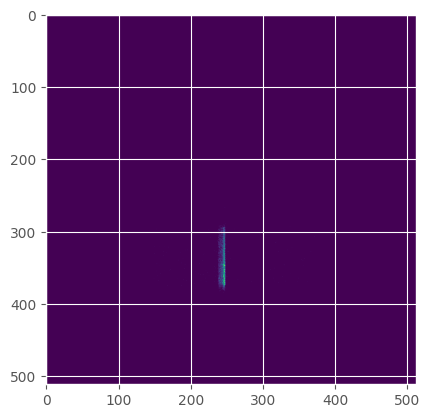

In [73]:
plt.imshow(hists[0].data_2D)

Trial number 19
Trial values: peak_distance 4.206e-03 fwhm 5.720e-03 int -5.105e+00
Trial dw:
{'h_sigma': 0.002539848958215076, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.0028875819228610577, 'h_peak': -0.003427734374999991, 'v_sigma': 0.005205385797780787, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.006155236559692996, 'v_peak': 0.0024374999999999813, 'integral_intensity': 3673.731436128989, 'peak_intensity': 164.91681681248994, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


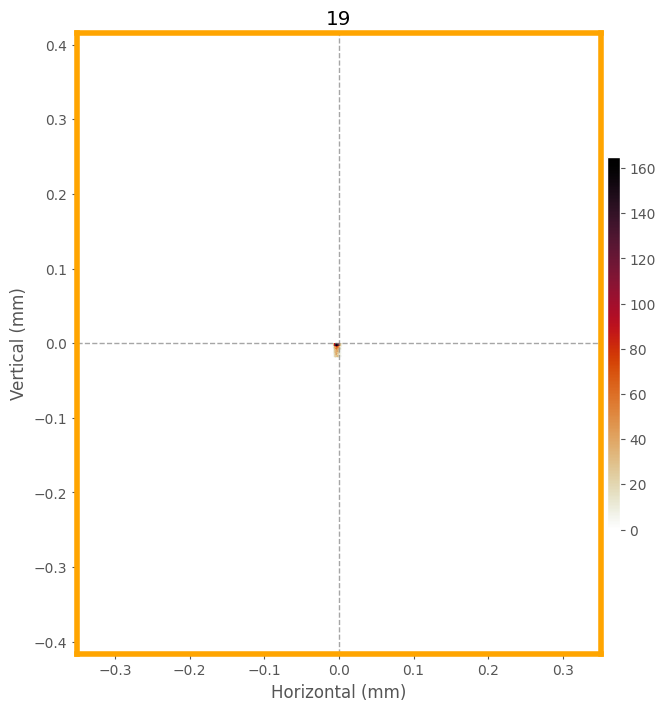

Trial number 31
Trial values: peak_distance 1.063e-03 fwhm 2.320e-02 int -3.197e+00
Trial dw:
{'h_sigma': 0.007725176817970884, 'h_fwhm': 0.009597656249999975, 'h_centroid': -0.002161917506224668, 'h_peak': -0.0006855468749999982, 'v_sigma': 0.012310903662252234, 'v_fwhm': 0.02112499999999984, 'v_centroid': -0.01122080679517563, 'v_peak': 0.0008124999999999938, 'integral_intensity': 3713.7797273034107, 'peak_intensity': 24.449729665414065, 'gaussian_fit': {}}
Actual fwhm 0.023203030631647168


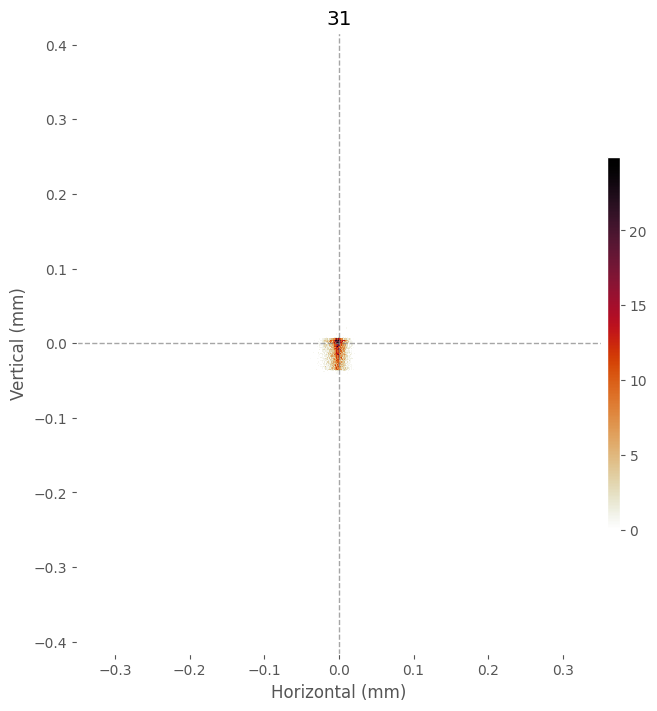

Trial number 52
Trial values: peak_distance 3.189e-03 fwhm 5.720e-03 int -4.805e+00
Trial dw:
{'h_sigma': 0.019710959557850197, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.003095033023306437, 'h_peak': 0.0020566406249999947, 'v_sigma': 0.0023555013735964544, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.003983880423393242, 'v_peak': 0.0024374999999999813, 'integral_intensity': 3611.963419352089, 'peak_intensity': 122.06413536400127, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


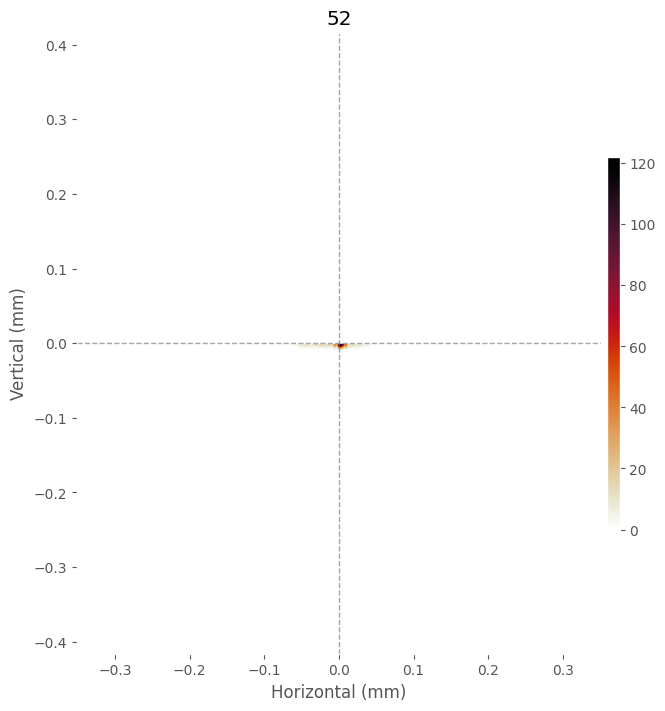

Trial number 53
Trial values: peak_distance 1.615e-02 fwhm 4.423e-03 int -5.065e+00
Trial dw:
{'h_sigma': 0.010179348874463595, 'h_fwhm': 0.004113281249999989, 'h_centroid': 0.01837329793701225, 'h_peak': 0.014396484375000018, 'v_sigma': 0.0031476971999844744, 'v_fwhm': 0.0016249999999999876, 'v_centroid': 0.00469699480806764, 'v_peak': -0.0073124999999999996, 'integral_intensity': 3630.681312207144, 'peak_intensity': 158.39984564357346, 'gaussian_fit': {}}
Actual fwhm 0.00442263582511622


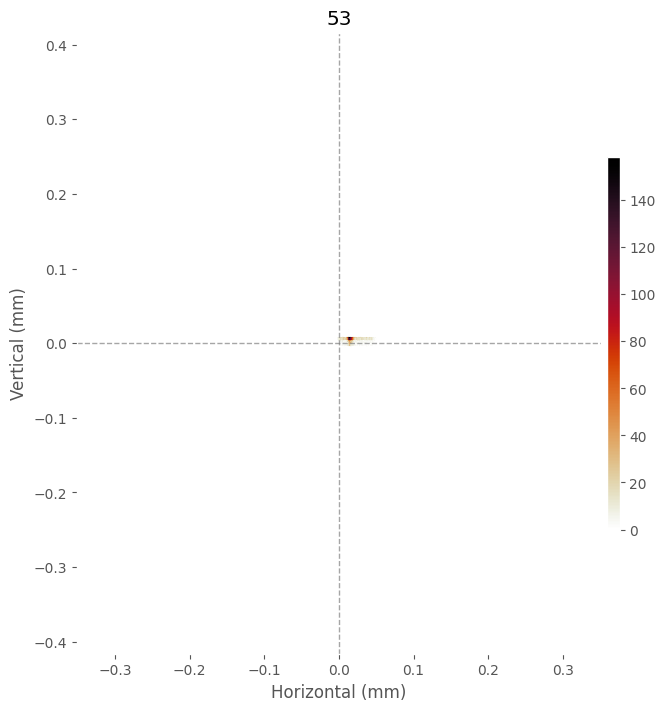

Trial number 57
Trial values: peak_distance 6.223e-03 fwhm 5.720e-03 int -5.281e+00
Trial dw:
{'h_sigma': 0.010956971198830648, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.013676851891349867, 'h_peak': 0.006169921874999984, 'v_sigma': 0.0025057994901159565, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.0007047843773862442, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3650.501748618189, 'peak_intensity': 196.537724592788, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


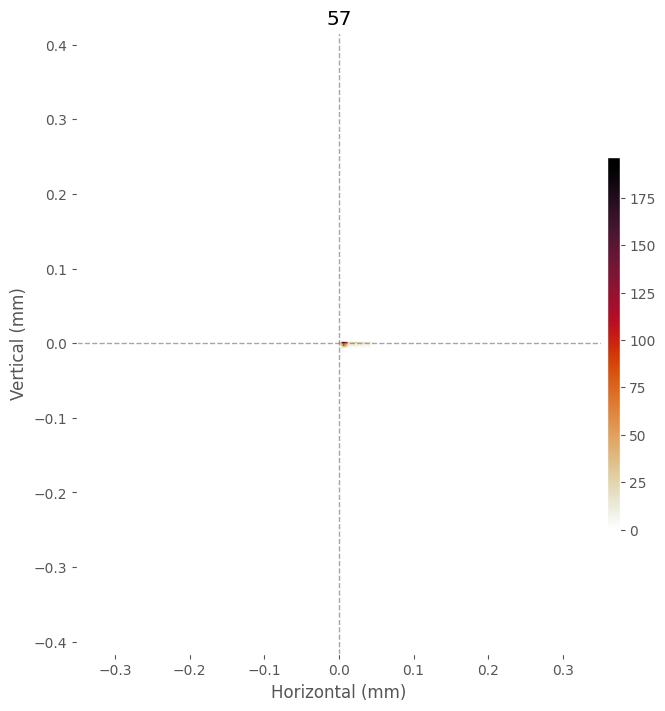

Trial number 121
Trial values: peak_distance 2.211e-03 fwhm 7.045e-03 int -5.207e+00
Trial dw:
{'h_sigma': 0.0099794338555909, 'h_fwhm': 0.006855468749999982, 'h_centroid': 0.006208246530678106, 'h_peak': -0.0020566406249999947, 'v_sigma': 0.0021237999393647995, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.00038231660217749304, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3677.0140694300694, 'peak_intensity': 182.54514709394488, 'gaussian_fit': {}}
Actual fwhm 0.0070454294959375096


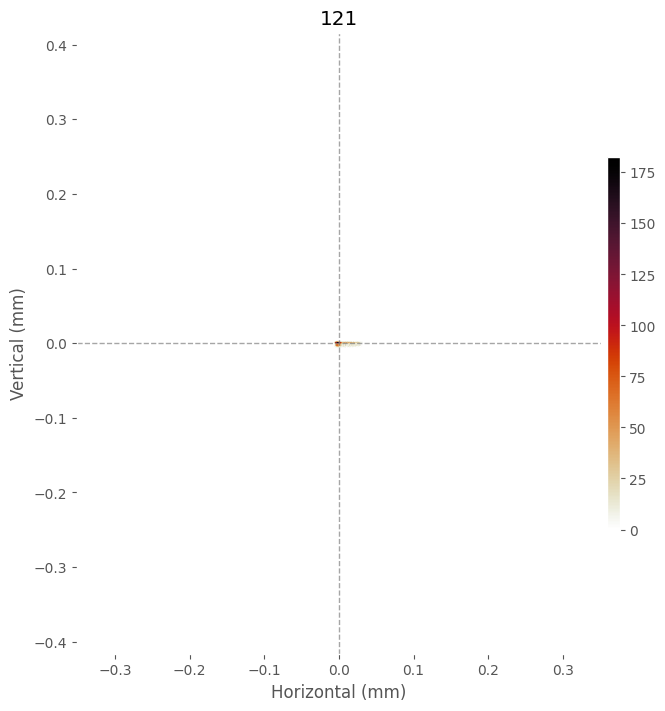

Trial number 130
Trial values: peak_distance 2.211e-03 fwhm 5.720e-03 int -4.723e+00
Trial dw:
{'h_sigma': 0.026414695543703053, 'h_fwhm': 0.005484374999999986, 'h_centroid': -0.0034803658049668146, 'h_peak': -0.0020566406249999947, 'v_sigma': 0.002267470640777782, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.0009355182407406558, 'v_peak': -0.0008124999999999938, 'integral_intensity': 3686.948993405012, 'peak_intensity': 112.51821846295687, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


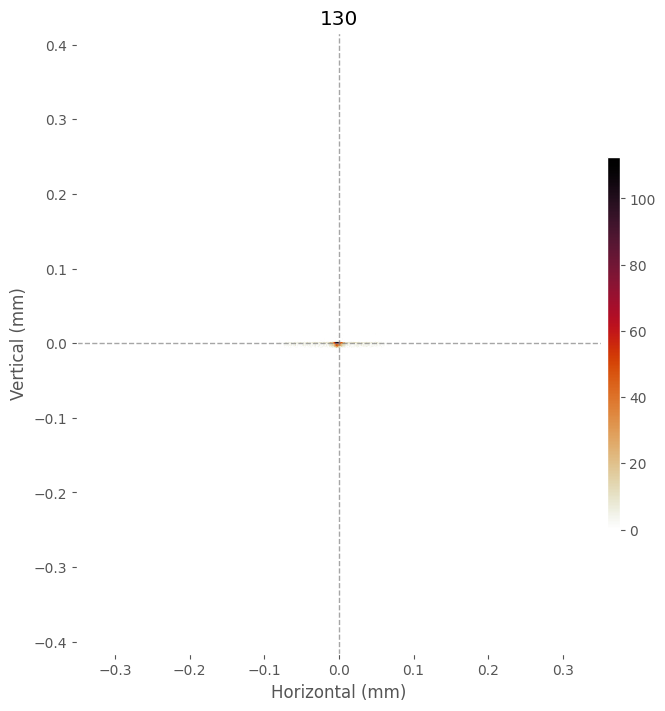

Trial number 136
Trial values: peak_distance 5.729e-03 fwhm 5.720e-03 int -5.208e+00
Trial dw:
{'h_sigma': 0.012021791492404947, 'h_fwhm': 0.005484374999999986, 'h_centroid': 0.009800385074922912, 'h_peak': 0.0006855468749999982, 'v_sigma': 0.001870525745496553, 'v_fwhm': 0.0016249999999999876, 'v_centroid': 0.004302811563550732, 'v_peak': -0.005687500000000012, 'integral_intensity': 3657.6445513677086, 'peak_intensity': 182.73292324660724, 'gaussian_fit': {}}
Actual fwhm 0.0057200519351335265


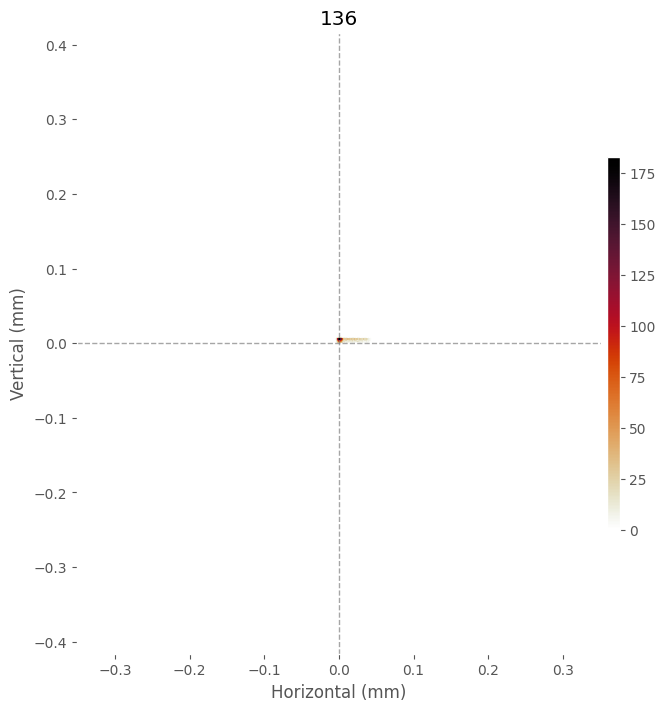

In [122]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

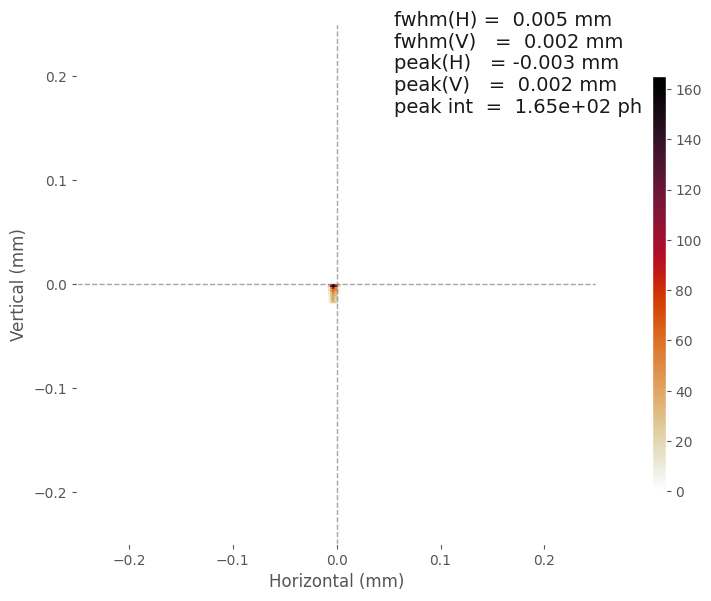

In [123]:

tnum = nash_trial.number
dw = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)
hist = hists[tnum]
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, )#norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dw['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dw['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dw['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dw['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dw['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.165, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.7))
plt.show()

In [101]:
[t.values for t in study.trials]

[[0.0905505300842304, 0.1384854709014175, -2.9333957863556175],
 [0.23724930980007097, 0.20536526580421102, -2.151751135518224],
 [0.10518781594621628, 0.0964049130537172, -1.0895600053149403],
 [0.0734640428470324, 0.24722317511337982, -1.7066775964218301],
 [0.026252727548491946, 0.16394893289621876, -3.687334114270199],
 [0.07859467724353582, 0.2738488235604378, -1.7014209532588682],
 [0.06863168130115006, 0.21160312435425124, -2.2623689223479735],
 [0.020630503896900746, 0.07472902650574502, -3.9260396475251067],
 [0.024131942461655485, 0.10315828477481528, -2.9085673918925985],
 [0.09873212357972683, 0.2941276663980755, -2.6358411952787946],
 [0.02742187499999993, 0.0758868015167308, -3.8552343732284724],
 [0.05493996190445061, 0.060151162306415554, -2.992912246331027],
 [0.013710937499999964, 0.03921365641918592, -4.459796371063467],
 [0.28115509013290224, 0.08966721057608708, -1.886836605420869],
 [0.015428226295526495, 0.0479815972734381, -3.8733287026959813],
 [0.0590465412519

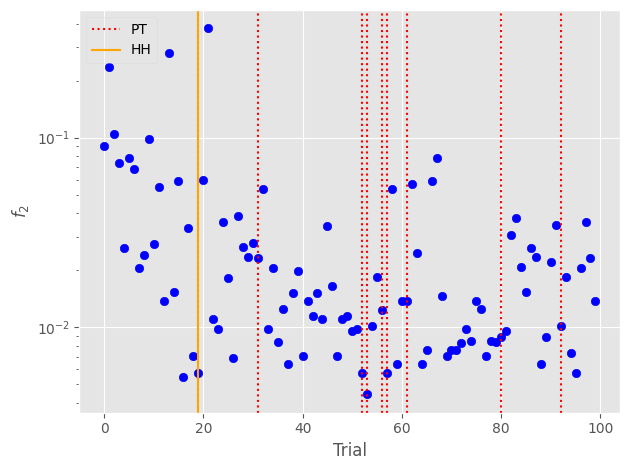

In [102]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[0] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_2$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

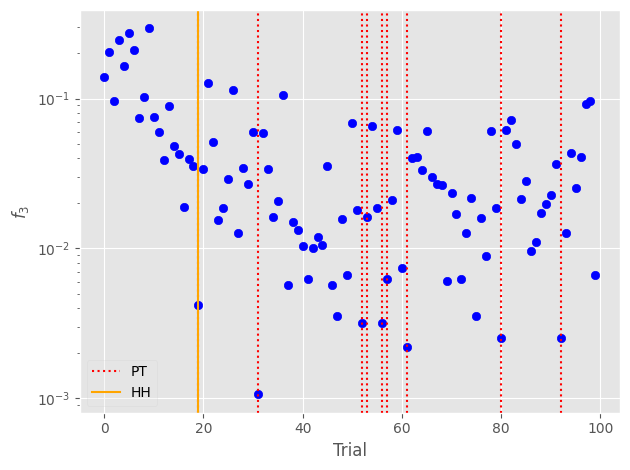

In [103]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[1] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_3$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
attribs_init

{'fwhm': 0.0905505300842304,
 'peak_distance': 0.1384854709014175,
 'negative_log_peak_intensity': -2.9333957863556175}

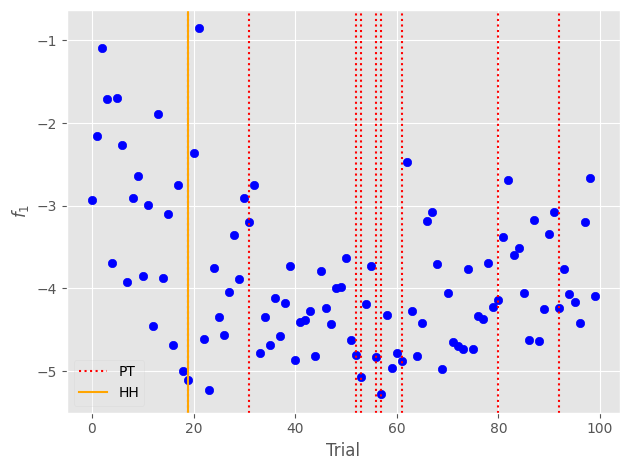

In [105]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials if t.values is not None]
y = [t.values[2] for t in study.trials if t.values is not None]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_1$')
#plt.yscale('symlog')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
attribs_focus

{'fwhm': 0.005242287920517273,
 'peak_distance': 0.001063076087503737,
 'negative_log_peak_intensity': -5.726095206772236}

In [107]:
attribs_focus

{'fwhm': 0.005242287920517273,
 'peak_distance': 0.001063076087503737,
 'negative_log_peak_intensity': -5.726095206772236}

In [108]:
colors = []
c_this = 0
for ix in range(ints_flat.size):
    if ix < 80: 
        c_this = 0
    else:
        c_this = (ix - 80) // 50 + 1
    colors.append(c_this)

optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[1]], 
                                                  target_names=['fwhm', 'peak_location'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['peak_distance'], color='green', label='True')
plt.yscale('log')
plt.xscale('log')

NameError: name 'ints_flat' is not defined

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75782/3908915646.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],


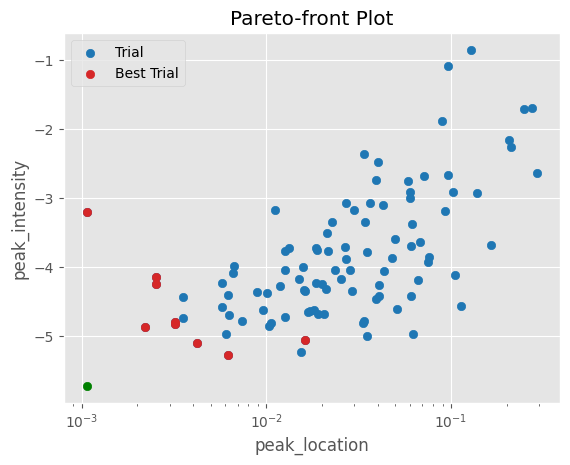

In [109]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],
                                                 target_names=['peak_location', 'peak_intensity'])

plt.scatter(attribs_focus['peak_distance'], attribs_focus['negative_log_peak_intensity'], color='green', label='True')
plt.xscale('log')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75782/2296441054.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],


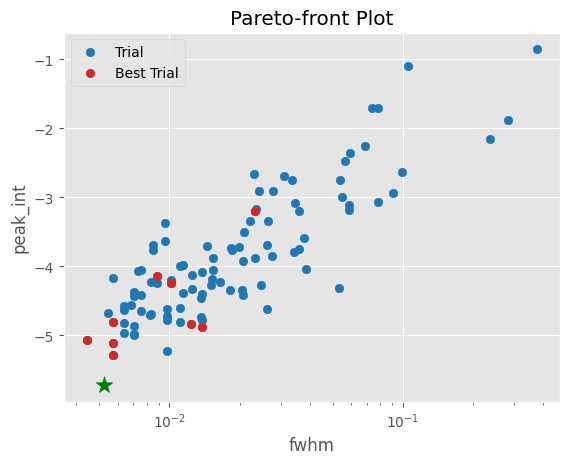

In [110]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],
                                                 target_names=['fwhm', 'peak_int'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['negative_log_peak_intensity'], color='green', label='True', s=155, marker='*')
plt.xscale('log')